# Predict hoax using scaled features

## TODOs:

- implement randomforest and xgboost, as in the paper
- graph the test scores alongside cross-val scores
- fix my StandardScaler implementation per Geoff's note ([link](https://stackoverflow.com/questions/51459406/how-to-apply-standardscaler-in-pipeline-in-scikit-learn-sklearn))

## Notes: Struggles with model fit without SFS

Goal: Match or surpass the $R^2$ achieved with unscaled features

#### ➜ Fewer coefficients present without scaling. Why?

- There was a typo and a feature slipped through that wasn't supposed to
    - ➜ fixed
    - The sets are the same now, but the phenomenon is remaining.
- Maybe it's because the intercept was scaled to zero?  
    - ➜ Try only scaling the original floats.
    - Score improved to .54/.5 , but unscaled remains .6
- Look at (unscaled_coeff / $\sigma$) to understand feature importance
    - ➜ Try repeating the regression with these features only
    - Score improved to .55/.5 , and unscaled remains .58
- Checked Lasso (with all features)
    - ➜ same results as Ridge: .54/.5
- Relaxed my limitation of C,
    - ➜ improved to .57/.5 with C=6
- Ran logistic regression on unscaled features with no regularization
    - ➜ improved to .61/.5
    - Far out-performed the paper-author's models
- Let's try SFS with scaled features
    - Success!
- Conclusion:
    - The unscaled data was causing regularization to do feature selection in a better way.
    - When the feature selection was improved with 

## Notes: sklearn GridSearchCV vs. customization

### When to use sklearn's GridSearchCV to wrap SFS?

- Technical particularity:
    - It's only possible to get access to the SFS instance for the param combination that GridSearchCV found to be optimal.
    - This mitigates output complexity, but prevents thorough review.
    - It would prevent a review of both SFFS and SFBS within the same gridsearch as is done here, for instance.
- Pros
    - GridSearchCV is great for automated production applications, to make the code robust, concise, and palatable for other users.
- Cons
    - GridSearchCV wouldn't let me do a viz overview of the param_grid outputs.
    - (it's grid ***search***, not grid ***exploration***.) 

#### Previous thoughts on why not to use sklearn's GridSearchCV with SFS:

## Get hoax data

### imports

In [1]:
import os, re, patsy
import pandas as pd, numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
path = '/home/bhrdwj/git/predwikt/data/raw/wiki_reliability/unzipped/'

In [2]:
fea = (pd.read_csv(path+'hoax_features.csv', usecols=lambda x: x not in ['Unnamed: 0'])
       .rename(columns={'headings_by_level(2)':'headings_by_level_2', 'revision_id.key':'revision_id_key'}))

### train test split

#### Make series of negative revisions and their revision keys, and vice versa

In [3]:
neg_revs = fea[['revision_id', 'revision_id_key', 'has_template']]
neg_revs = neg_revs.loc[neg_revs.has_template==0].set_index('revision_id')['revision_id_key']
pos_revs = fea[['revision_id', 'revision_id_key', 'has_template']]
pos_revs = pos_revs.loc[pos_revs.has_template==1].set_index('revision_id')['revision_id_key']

neg_revs.shape #, pos_revs.shape

(1390,)

#### Test-train split the neg_revs, and form dfte and dftr

In [4]:
neg_revs_tr, neg_revs_te = train_test_split(neg_revs, test_size=.2, random_state=0)
pos_revs_tr = pos_revs[neg_revs_tr.values]
pos_revs_te = pos_revs[neg_revs_te.values]

In [5]:
revs_tr = pd.concat((neg_revs_tr, pos_revs_tr))
revs_te = pd.concat((neg_revs_te, pos_revs_te))

In [6]:
fea_rev = fea.set_index('revision_id')
dftr = fea_rev.loc[revs_tr.index].dropna()
dfte = fea_rev.loc[revs_te.index].dropna()

In [7]:
del neg_revs, pos_revs, neg_revs_tr, pos_revs_tr, neg_revs_te, pos_revs_te, revs_tr, revs_te, fea_rev

In [8]:
dftr[dftr.columns.difference(['page_id','revision_id_key','has_template'])].describe().T.sort_values(by='mean');

### prep

In [9]:
# remove non-features; onehotify categoricals
ytr = dftr.has_template
Xtr = dftr[dftr.columns.difference(['page_id','revision_id_key','has_template'])]
Xtr = patsy.dmatrix('~ '+' + '.join(Xtr.columns), data=Xtr, NA_action='drop', return_type='dataframe')

yte = dfte.has_template
Xte = dfte[dfte.columns.difference(['page_id','revision_id_key','has_template'])]
Xte = patsy.dmatrix('~ '+' + '.join(Xte.columns), data=Xte, NA_action='drop', return_type='dataframe')

# make complete list of columns in case the test set doesn't include any of a rare class
Xcols = list(
    set(Xtr.columns.tolist())
    .union(set(Xte.columns.tolist()))
)

for col in Xcols:
    if col not in Xte:
        Xte[col] = 0
    if col not in Xtr:
        Xtr[col] = 0
        
Xtr = Xtr.reindex(columns=Xcols)
Xte = Xte.reindex(columns=Xcols)

In [10]:
Xtr.shape, Xte.shape

((2221, 25), (556, 25))

## Fit model

### imports

In [129]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### functions

##### get_fitfeats_sfs_pipe

In [53]:
def bh_sfs_gridsearch(Xtr, ytr, pipe, param_grid:dict):
    """
    Concept:
        Like sklearn's GridSearch, but relying on sfs for the CV
        Value-add: Returns all feature sets from SFFS and SFBS runs and sub-runs for each parameter combo
    Args:
        Xtr: pd.DataFrame of features
        ytr: pd.Series target
        pipe: sklearn Pipeline ending in a mlxtend SequentialFeatureSelector instance.
        param_grid: dict of lists, params of pipe, input for sklearn ParameterGrid
    Returns:
        dict:
        - keys are numbers starting in 1, for each cell of ParameterGrid
        - values are lists of feature names
    """
    print(f'start time: {dt.now()}')
    pg = {i:j for i,j in enumerate(ParameterGrid(param_grid), start=1)}
    sfs_featdict = {}
    sfs_scoredict = {}
    for i in pg:
        pipe.set_params(**pg[i]).fit(Xtr, ytr)
        k_feats = pg[i]['sfs__k_features']
        idx_tup = pipe.steps[-1][1].get_metric_dict()[k_feats]['feature_idx']
        
        d = {k:list(v['feature_idx']) for k,v in pipe.steps[1][1].subsets_.items()}  # IMPROVEMENT: change pipe.steps[1] to directly look for the sfs step
        for j in d: d[j] = Xtr.columns[d[j]]
        sfs_featdict[i] = d
        
        s = {k:v['avg_score'] for k,v in pipe.steps[1][1].subsets_.items()} # IMPROVEMENT: change pipe.steps[1] to directly look for the sfs step
        sfs_scoredict[i] = s
    print(f'finish time: {dt.now()}')
    return sfs_featdict, sfs_scoredict

### instances

In [130]:
scaler = StandardScaler()
lr_sfs = LogisticRegression(penalty='l2', max_iter=1000, fit_intercept=True)
cv_sfs = StratifiedKFold(n_splits=5, shuffle=False)
sfs = SFS(estimator=lr_sfs, forward=True, floating=False, scoring='accuracy', cv=cv_sfs)
sffs = SFS(estimator=lr_sfs, forward=True, floating=True, scoring='accuracy', cv=cv_sfs)
sfbs = SFS(estimator=lr_sfs, forward=False, floating=True, scoring='accuracy', cv=cv_sfs)
sfs_pipe = Pipeline([('scaler', scaler),('sfs', sfs)])

### fit

#### sffs

In [131]:
sfs_pipe_param_grid = {
    'sfs': [sffs, sfbs],
    'sfs__k_features': [1, len(Xtr.columns)],
    'sfs__estimator': [lr_sfs],
    'sfs__estimator__C': [.1]
}

sfs_featdict, sfs_scoredict = bh_sfs_gridsearch(Xtr, ytr, sfs_pipe, sfs_pipe_param_grid)

start time: 2021-12-31 16:04:04.166107
finish time: 2021-12-31 16:07:01.764171


#### pickle

In [132]:
import pickle

with open('../data/processed/sfs_scoredict.StratifiedKFoldkle','wb+') as f:
    pickle.dump(sfs_scoredict, f)
with open('../data/processed/sfs_featdict.pickle','wb+') as f:
    pickle.dump(sfs_featdict, f)

# with open('../data/processed/sfs_featdict.pickle','rb') as f:
#     sfs_featdict = pickle.load(f)
# with open('../data/processed/sfs_scoredict.pickle','rb') as f:
#     sfs_scoredict = pickle.load(f)

## Manage model output

### extract feats

#### get onehot df ~ features selected by sfs

##### munge_onehotdf_from_sfs_featdict (function)

In [133]:
def munge_onehotdf_from_sfs_featdict(sfs_featdict):
    
    # simple 1D list of sfs  feats
    sfs_feat_set = set()
    for i in sfs_featdict:              # runs
        for j in sfs_featdict[i]:       # kfeats
            sfs_feats = list(sfs_feat_set.union(set(sfs_featdict[i][j])))
    
    # make multiindex columns and empty dataframe
    col = pd.MultiIndex.from_tuples(
        [(j,k) for j in sfs_featdict for k in sfs_featdict[j]])
    idx = pd.Index(sfs_feats, name='feature')
    df = pd.DataFrame('-', idx, col)
    
    # insert onehots into df
    for i in sfs_feats:                           # feats
        for j in sfs_featdict:                        # runs
            for k in sfs_featdict[j]:             # steps within run
                df.loc[i,(j,k)] = int(i in sfs_featdict[j][k])
    
    df = df.astype(int) 
    return df

##### get df

In [134]:
sfs_onehots = munge_onehotdf_from_sfs_featdict(sfs_featdict)

#### get simple 1D lists of sfs runs, kfeats, and feats

In [135]:
sfs_runs = list(sfs_featdict.keys())

sfs_feat_set, sfs_kfeats_set = set(), set()
for i in sfs_featdict:              # runs
    for j in sfs_featdict[i]:       # kfeats
        sfs_feats = list(sfs_feat_set.union(set(sfs_featdict[i][j])))
        sfs_kfeats = list(sfs_kfeats_set.union(set([j])))

#### sort the index of features by occurence

##### count occurrences of features to sort the index

In [136]:
idx = pd.IndexSlice
sfs_feat_usecounts = sfs_onehots.loc[:,idx[1,:]].sum(axis=1)
for i in sfs_featdict:
    sfs_feat_usecounts += sfs_onehots.loc[:,idx[i,:]].sum(axis=1)

##### sort features by frequency of occurence in sfs cases

In [137]:
sfs_onehots = sfs_onehots.reindex(index=sfs_feat_usecounts.sort_values(ascending=False).index)
sfs_onehots = sfs_onehots.sort_index(axis=1)

## Viz

##### imports

In [138]:
import matplotlib
%matplotlib inline
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import seaborn as sns

#### plot feature selection

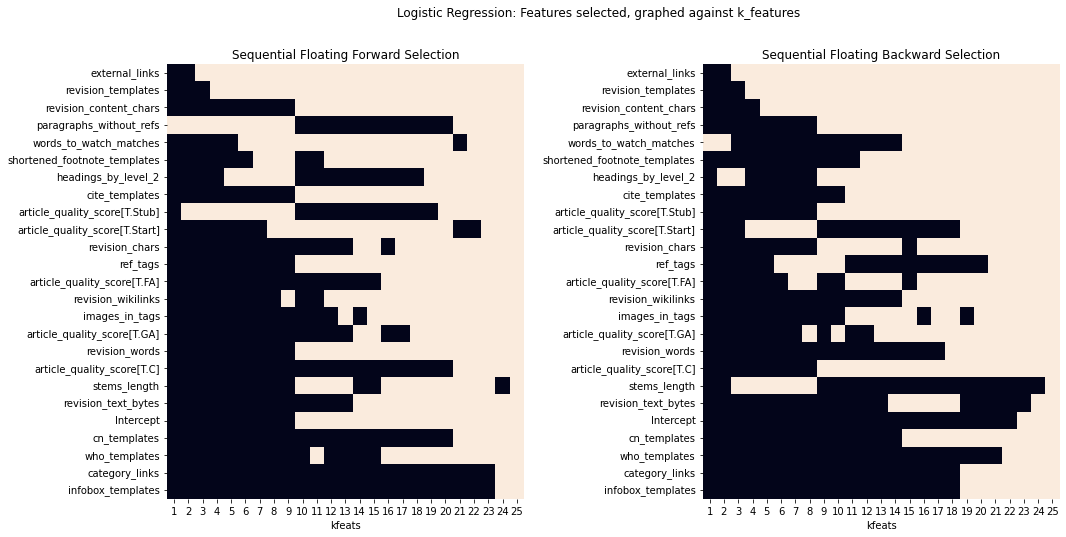

In [186]:
feat_fig, ax = plt.subplots(1,2, figsize=(16,8))
feat_fig.subplots_adjust(wspace=.5)

(sns.heatmap(
    sfs_onehots.loc[:,idx[2,:]].T.droplevel(level=0).T, 
    ax=ax[0], cbar=False)
    .set(ylabel=None, xlabel='kfeats')   
)
(sns.heatmap(
    sfs_onehots.loc[:,idx[3,:]].T.droplevel(level=0).T, 
    ax=ax[1], cbar=False)
    .set(ylabel=None, xlabel='kfeats')
)

ax[0].set_title('Sequential Floating Forward Selection')
ax[1].set_title('Sequential Floating Backward Selection')
feat_fig.suptitle('Logistic Regression: Features selected, graphed against k_features')
feat_fig.show()

#### plot cv scores

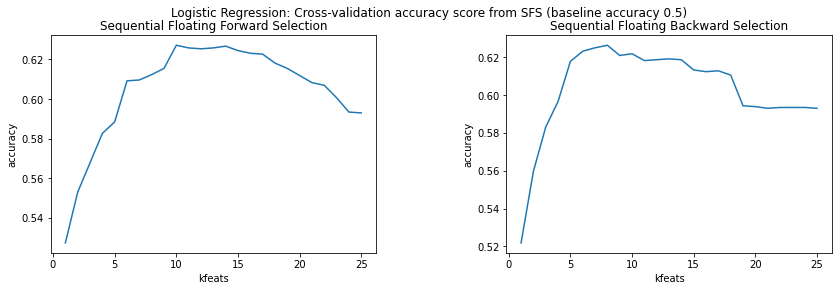

In [188]:
scor_fig, ax = plt.subplots(1,2, figsize=(14,4))
scor_fig.subplots_adjust(wspace=.4)

pd.Series(sfs_scoredict[2]).plot(ax=ax[0])
pd.Series(sfs_scoredict[3]).plot(ax=ax[1])
for axis in ax:
    axis.set_xlabel('kfeats')
    axis.set_ylabel('accuracy')
ax[0].set_title('Sequential Floating Forward Selection')
ax[1].set_title('Sequential Floating Backward Selection')
scor_fig.suptitle('Logistic Regression: Cross-validation accuracy score from SFS (baseline accuracy 0.5)')
scor_fig.show()

### Get top 5 feats sets by cross-val score

##### create empty dataframe for scores

In [141]:
df_scores = pd.DataFrame('-', ['score'], sfs_onehots.columns)

##### insert scores into dataframe

In [142]:
for j in sfs_runs:                        # runs
    for k in sfs_featdict[j]:             # steps within run
        df_scores.loc['score',(j,k)] = sfs_scoredict[j][k]   
df_scores = df_scores.sort_index(axis=1)

##### select the 5 multiindices that had the best cross-val scores across sffs and sfbs

In [143]:
cols_5best = df_scores.T.astype(float).nlargest(5, columns='score').T.columns
scores_5best = df_scores.T.astype(float).nlargest(5, columns='score').values.tolist()

##### use the indices to make a dataframe of onehots; then get lists of features

In [144]:
feats_5best_onehots = sfs_onehots[cols_5best].T.droplevel(level=0).reset_index(drop=True).T
feats_5best = {}
for i in feats_5best_onehots.columns:
    feats_5best[i] = set(feats_5best_onehots[i].loc[lambda x: x>0].index.tolist())

In [171]:
feats_5best;

## Tune hyperparameters

In [166]:
sfs_featdict[2][1]

Index(['paragraphs_without_refs'], dtype='object')

In [168]:
test_scores = {}
best_Cs = {}
for i in sfs_featdict:             # runs
    test_scores[i] = {}
    best_Cs[i] = {}
    for j in sfs_featdict[i]:       # steps
        lr_C = LogisticRegressionCV(penalty='l2', Cs=[.01,.1,1,10,100], max_iter=1000, fit_intercept=True)
        lr_C.fit(Xtr[sfs_featdict[i][j]], ytr)
        best_Cs[i][j] = lr_C.C_[0]
        test_scores[i][j] = lr_C.score(Xte[sfs_featdict[i][j]], yte)

/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bhrdwj/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

#### Plot test scores

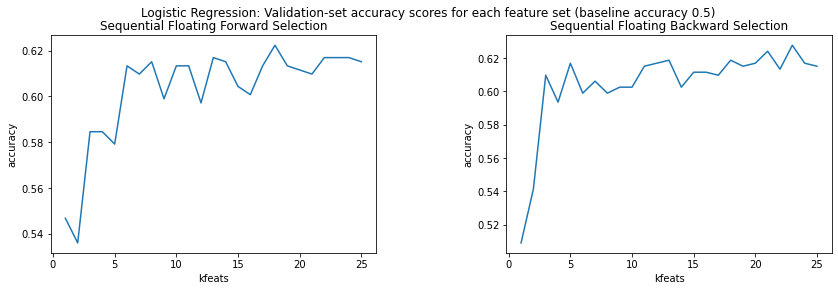

In [173]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
fig.subplots_adjust(wspace=.4)

pd.Series(test_scores[2]).plot(ax=ax[0])
pd.Series(test_scores[3]).plot(ax=ax[1])
for axis in ax:
    axis.set_xlabel('kfeats')
    axis.set_ylabel('accuracy')
ax[0].set_title('Sequential Floating Forward Selection')
ax[1].set_title('Sequential Floating Backward Selection')
fig.suptitle('Logistic Regression: Validation-set accuracy scores for each feature set (baseline accuracy 0.5)')
plt.show()

#### Plot optimal C from LogisticRegressionCV

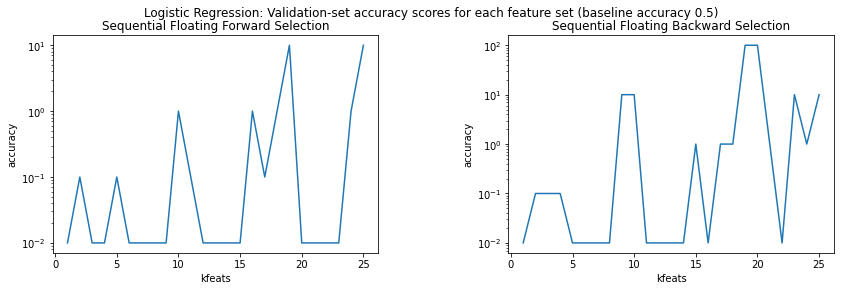

In [175]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
fig.subplots_adjust(wspace=.4)

pd.Series(best_Cs[2]).plot(ax=ax[0])
pd.Series(best_Cs[3]).plot(ax=ax[1])
for axis in ax:
    axis.set_xlabel('kfeats')
    axis.set_ylabel('accuracy')
    axis.set_yscale('log')
ax[0].set_title('Sequential Floating Forward Selection')
ax[1].set_title('Sequential Floating Backward Selection')
fig.suptitle('Logistic Regression: Validation-set accuracy scores for each feature set (baseline accuracy 0.5)')
plt.show()

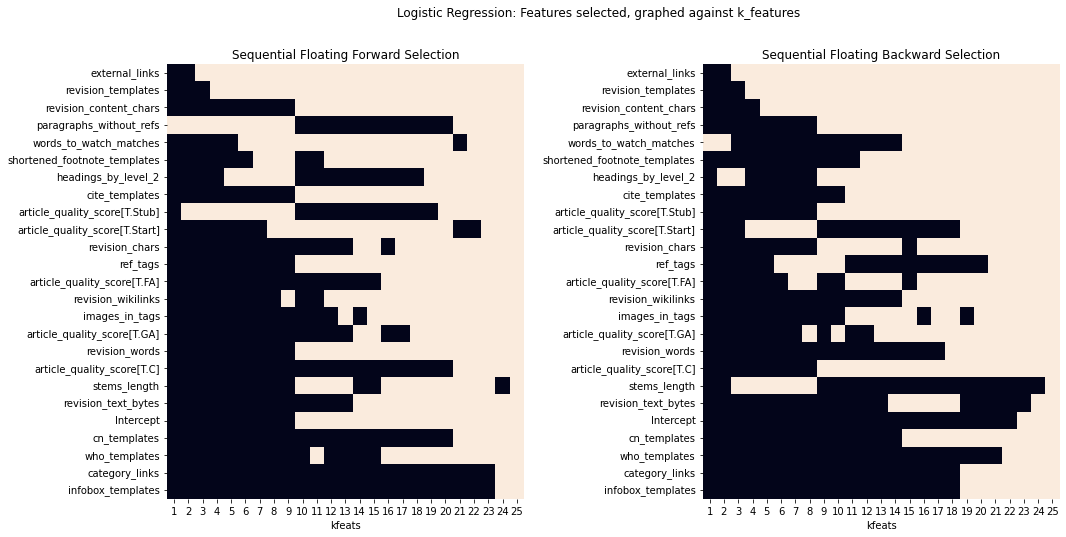

In [187]:
feat_fig

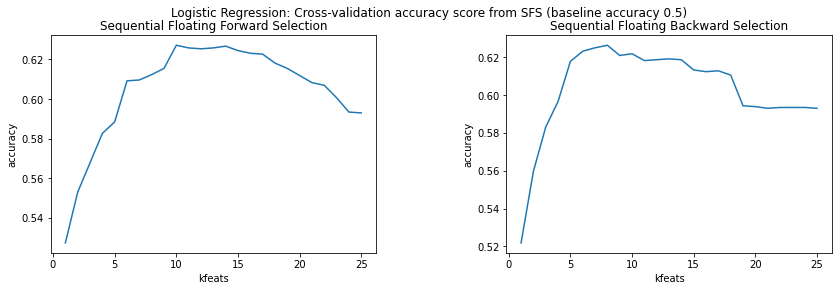

In [189]:
scor_fig

In [147]:
best_Cs

{0: 1.0, 1: 1.0, 2: 0.01, 3: 0.01, 4: 0.1}

In [148]:
scores_5best # best 5 cross-validation scores

[[0.6271910112359551],
 [0.6267395485373013],
 [0.6262931470796639],
 [0.625840672132807],
 [0.6258396598846038]]

In [149]:
test_scores # scores on test data

{0: 0.6115107913669064,
 1: 0.6097122302158273,
 2: 0.5989208633093526,
 3: 0.6079136690647482,
 4: 0.6169064748201439}

In [150]:
list(map(len,feats_5best.values()))

[10, 14, 8, 13, 11]

### Choose a feature set

The 10-feature set had the best cross-val score and almost the best test score.  
Its features are also a strict subset of three other top-5 sets, which may suggest lower variance.
It was also optimized with a moderate regularization penalty.

Choose the 10 feature set, and C=1.0. 

## Conclusions

- The smooth rising and falling of cross-val scores suggests a consistent bias-variance tradeoff
- It's useful to see the curves for forwards and backwards, and the 